# Import Library

In [1]:
!pip install transformers --quiet
!pip install emoji --quiet
!pip install wordcloud --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.7 MB/s eta 0:00:00


In [2]:
import re
import string
import numpy as np
import pandas as pd
import emoji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

import torch
from torch.utils.data import Dataset

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)

# Load Dataset

In [3]:
from google.colab import files
files.upload()

Saving data.zip to data.zip


{'data.zip': b'PK\x03\x04\x14\x00\x00\x00\x00\x00b\x95\x13[\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x00 \x00data/UT\r\x00\x07Hc\xa4hDi\xa4hHc\xa4hux\x0b\x00\x01\x04\xf5\x01\x00\x00\x04\x14\x00\x00\x00PK\x03\x04\x14\x00\x08\x00\x08\x008\xbc\x83Z\x00\x00\x00\x00\x00\x00\x00\x008m\x08\x00\x1a\x00 \x00data/tokopedia_reviews.csvUT\r\x00\x07m\xb8\xeegJc\xa4hHc\xa4hux\x0b\x00\x01\x04\xf5\x01\x00\x00\x04\x14\x00\x00\x00\xec\xbd]\x8f\xdch\x96\x1ex\xbf\xbf\x82\xa5E\xd5H\xd3\x14\x95\x19\xa9T}\xccE!RRI\xaa\x94R\xb9\xcaT\xd7\x94\xef\x18\x11T\x04\x93\x11d4\x83,)\xe6jl\xac\xd7\x80\xe1\xf1\xd8\x18\x03\xdb\xb3\xd8A\xc1\xc0x\x80\xc5\xc27s\xb1X\xaf\r_\xf4O\xe9?\xb0\xf5\x13\xf6<\xcf9\xef\xcb\x97\x11Y\x0c\xb5\xdd;\x98]Ou\x97J\x99\xc1 _\xbe\x1f\xe7\xf39\xcf\xc9gq\x9d\xfd\x90g\xef\xe3:m\xf2r\x1e7\xf9*\xdb4\xe9j\xfd\xdf\x1d\xc7w6\xb3E4\xcb\xa7\x8b\xb4\x896\x93\xe5**\xb7i\xd46E\xb4\xca\xcb&\x8d\x8a\xbc\xceW\xd1(Z\xe4r}\xb4n\x9b\\\xaeN\xcb\xe8X\x7f\x13G\xeb\xac\xbci\xd3e\x84\xdbL\x96\xf3\xa8*\x92$Z\

In [4]:
!unzip data.zip -d ./

Archive:  data.zip
   creating: ./data/
  inflating: ./data/tokopedia_reviews.csv  
  inflating: ./data/tokopedia_products.csv  


In [5]:
df = pd.read_csv("/content/data/tokopedia_reviews.csv")

# Labeling

In [6]:
def label_sentiment(df):
    classifier = pipeline(
        "text-classification",
        model="w11wo/indonesian-roberta-base-sentiment-classifier",
        tokenizer="w11wo/indonesian-roberta-base-sentiment-classifier",
        truncation=True,
        padding=True,
        max_length=512
    )

    df['label'] = df['review'].astype(str).apply(lambda x: classifier(x)[0]['label'].lower())
    return df

df = label_sentiment(df)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [7]:
df['label'].value_counts()

,count
label,
negative,2368
positive,2132
neutral,300


# Oversampling

In [8]:
df_positif = df[df['label'] == 'positive']
df_negatif = df[df['label'] == 'negative']
df_netral  = df[df['label'] == 'neutral']

df_negatif_upsampled = resample(df_negatif,
                                 replace=True,
                                 n_samples=len(df_positif),
                                 random_state=42)

df_netral_upsampled = resample(df_netral,
                                replace=True,
                                n_samples=len(df_positif),
                                random_state=42)

df_balanced = pd.concat([df_positif, df_negatif_upsampled, df_netral_upsampled])

In [9]:
df_balanced['label'].value_counts()

,count
label,
positive,2132
negative,2132
neutral,2132


# EDA

In [10]:
def generate_wordcloud(df, label_name):
    text = ' '.join(df[df['label'] == label_name]['review'].tolist())
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        collocations=False,
        max_words=200
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"sentimen: {label_name}", fontsize=16)
    plt.show()

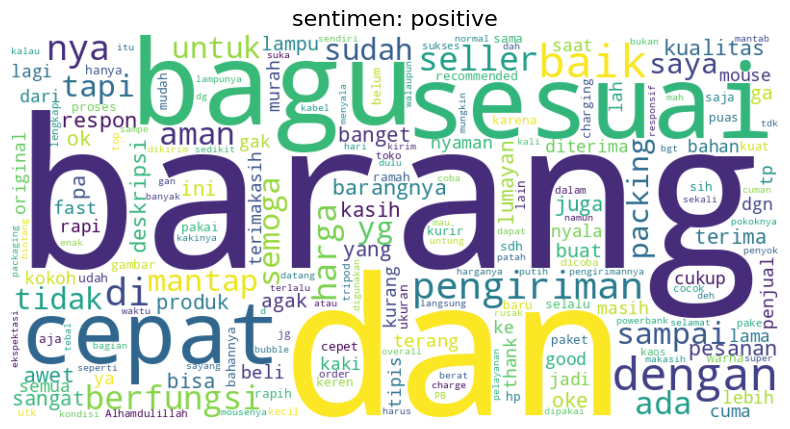

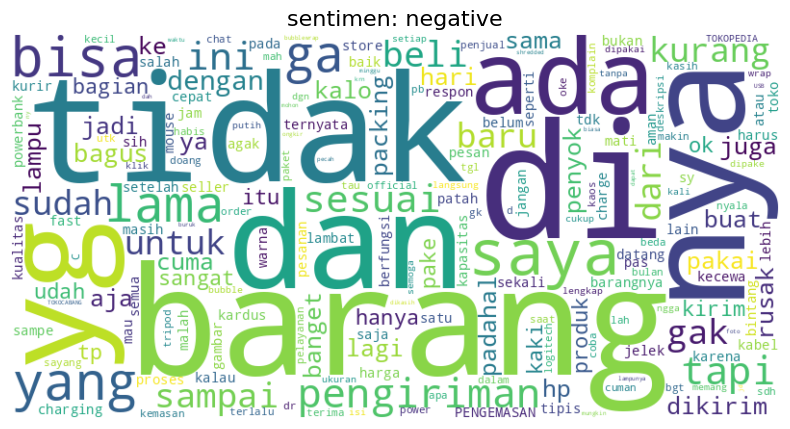

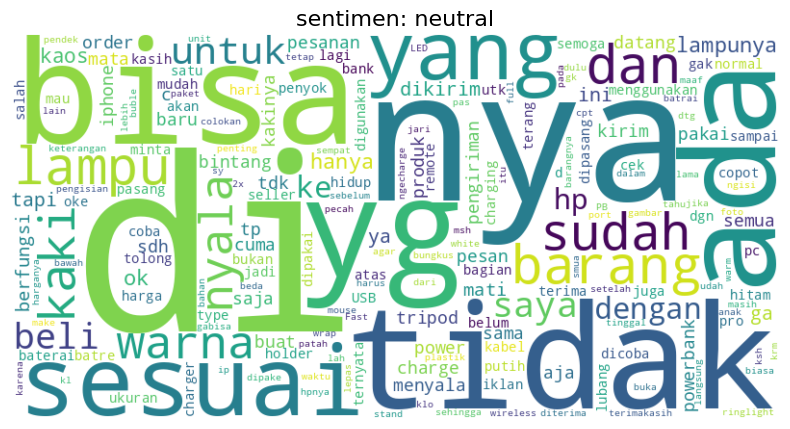

In [11]:
for label in df_balanced['label'].unique():
    generate_wordcloud(df_balanced, label)

# Preprocessing

In [12]:
kamus_alay = {
    'gk': 'nggak',
    'ga': 'nggak',
    'bgt': 'banget',
    'tp': 'tapi',
    'udh': 'sudah',
    'sy': 'saya',
    'dr': 'dari',
    'blm': 'belum',
    'tdk': 'tidak',
    'sbnrnya': 'sebenarnya',
    'bbrp': 'beberapa',
    'dpt': 'dapat',
    'trs': 'terus',
    'bgt': 'banget',
    'jg': 'juga',
    'krn': 'karena',
    'sm': 'sama',
    'udh': 'sudah',
    'aja': 'saja',
    'lg': 'lagi'
}

def normalize_text(text):
    return ' '.join([kamus_alay.get(w, w) for w in text.split()])

def clean_text(text):
    text = text.lower()
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = normalize_text(text)

    return text.strip()

In [13]:
df_balanced['cleaned_review'] = df_balanced['review'].astype(str).apply(clean_text)
df_balanced[['review', 'cleaned_review', 'label']].sample(5)

,review,cleaned_review,label
4065,Barang Bagus cuma pengirimanya lama banget,barang bagus cuma pengirimanya lama banget,negative
86,"charging ke hp lmyn lama, dan ngecharge ke pow...",charging ke hp lmyn lama dan ngecharge ke powe...,neutral
4577,"revisi, pembelian kedua, tapi ko ini malah sem...",revisi pembelian kedua tapi ko ini malah sempi...,negative
2051,"produk bagus dan berfungsi dengan baik, trims ...",produk bagus dan berfungsi dengan baik trims y...,positive
3034,"lama,pedagangnya sombong. tidak ramah sama pem...",lamapedagangnya sombong tidak ramah sama pembeli,negative


# Tokenize & Encoding

In [14]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [15]:
texts = df_balanced['cleaned_review'].tolist()
labels = df_balanced['label'].tolist()

le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

tokenized = tokenizer.batch_encode_plus(
    texts,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

Label mapping: {np.str_('negative'): np.int64(0), np.str_('neutral'): np.int64(1), np.str_('positive'): np.int64(2)}


# Create Dataset & Data Loader

## Custom Dataset Class

In [16]:
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

## Split Train & Val Set

In [17]:
train_idx, val_idx = train_test_split(
    list(range(len(encoded_labels))),
    test_size=0.1,
    stratify=encoded_labels,
    random_state=42
)

train_encodings = {key: val[train_idx] for key, val in tokenized.items()}
val_encodings   = {key: val[val_idx] for key, val in tokenized.items()}

train_labels = [encoded_labels[i] for i in train_idx]
val_labels   = [encoded_labels[i] for i in val_idx]

train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset   = ReviewDataset(val_encodings, val_labels)

# Modeling

## Fine-Tuning IndoBERT

In [18]:
model = BertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1',
    num_labels=3
)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [20]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

## Training

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

/tmp/ipython-input-3676571469.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: putrallan03 (putrallan03-gadjah-mada-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/tmp/ipython-input-1666202255.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.368300,0.305492,0.871875,0.873738,0.871960,0.871891
2,0.181100,0.289072,0.920312,0.920748,0.920356,0.919820
3,0.120400,0.309494,0.931250,0.931396,0.931333,0.930735
4,0.078800,0.398851,0.921875,0.921867,0.921979,0.921259
5,0.001100,0.387487,0.925000,0.924694,0.925080,0.924554


/tmp/ipython-input-1666202255.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-1666202255.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-1666202255.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-1666202255.py:7: UserWarning: To copy construct fro

TrainOutput(global_step=1800, training_loss=0.2171616338379681, metrics={'train_runtime': 818.996, 'train_samples_per_second': 35.141, 'train_steps_per_second': 2.198, 'total_flos': 1893101040552960.0, 'train_loss': 0.2171616338379681, 'epoch': 5.0})

## Evaluation

In [23]:
print(trainer.evaluate())

/tmp/ipython-input-1666202255.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.3094940483570099, 'eval_accuracy': 0.93125, 'eval_precision': 0.9313963554158741, 'eval_recall': 0.9313325435478917, 'eval_f1': 0.9307349381482748, 'eval_runtime': 4.3173, 'eval_samples_per_second': 148.24, 'eval_steps_per_second': 9.265, 'epoch': 5.0}


In [24]:
val_predictions = trainer.predict(val_dataset)

y_pred = np.argmax(val_predictions.predictions, axis=1)
y_true = val_predictions.label_ids

y_pred_labels = [le.inverse_transform([i])[0] for i in y_pred]
y_true_labels = [le.inverse_transform([i])[0] for i in y_true]

print(classification_report(y_true_labels, y_pred_labels, digits=4))

/tmp/ipython-input-1666202255.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


              precision    recall  f1-score   support

    negative     0.9206    0.9249    0.9227       213
     neutral     0.9336    0.9906    0.9613       213
    positive     0.9400    0.8785    0.9082       214

    accuracy                         0.9313       640
   macro avg     0.9314    0.9313    0.9307       640
weighted avg     0.9314    0.9313    0.9307       640



## Save Model

In [25]:
model.save_pretrained("content/model-sentimen-indobert")
tokenizer.save_pretrained("content/model-sentimen-indobert")

('content/model-sentimen-indobert/tokenizer_config.json',
 'content/model-sentimen-indobert/special_tokens_map.json',
 'content/model-sentimen-indobert/vocab.txt',
 'content/model-sentimen-indobert/added_tokens.json')

# Testing

In [26]:
new_texts = [
    "barang jelek, tdk sesuai kualitas yang tertera",
    "Sesuai Des, sejuh ini cukup baik",
    "Sebaiknya diinformasikan tidak tersedia kabel type c to type c yg hubungkan powerbank dgn HP"
]

In [27]:
new_texts_clean = [clean_text(t) for t in new_texts]

inputs = tokenizer(
    new_texts_clean,
    return_tensors='pt',
    padding=True,
    truncation=True,
    max_length=128
)

In [28]:
dummy_labels = [0] * len(new_texts_clean)
new_dataset = ReviewDataset(inputs, dummy_labels)

predictions = trainer.predict(new_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

/tmp/ipython-input-1666202255.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
label_decode = {v: k for k, v in label_mapping.items()}

for text, label in zip(new_texts, pred_labels):
    print(f"Review Product:\n{text}\nPredict Sentimen: \033[1m{label_decode[label]}\033[0m\n")

Review Product:
barang jelek, tdk sesuai kualitas yang tertera
Predict Sentimen: negative

Review Product:
Sesuai Des, sejuh ini cukup baik
Predict Sentimen: positive

Review Product:
Sebaiknya diinformasikan tidak tersedia kabel type c to type c yg hubungkan powerbank dgn HP
Predict Sentimen: neutral

